In [105]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/pic/barraxx.bmp
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/lenna.jpg

--2020-10-02 18:53:52--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/pic/barraxx.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600056 (586K) [image/bmp]
Saving to: ‘barraxx.bmp.1’

barraxx.bmp.1       100%[===================>] 585.99K  --.-KB/s    in 0.07s   

2020-10-02 18:53:52 (8.07 MB/s) - ‘barraxx.bmp.1’ saved [600056/600056]

--2020-10-02 18:53:52--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/lenna.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8145

Imports y funciones auxiliares

In [328]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2,fftshift,ifft2,ifftshift

def fft_c(x):
    return fftshift(fft2(x))
def ifft_c(x):
    return ifft2(ifftshift(x))
def get_gaussian_kernel(size,sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    return kernel

def get_delta(img):
    delta = np.zeros_like(img).astype(np.float64)
    delta[delta.shape[0]//2,delta.shape[1]//2] = 1
def get_expanded_kernel(img2conv,kernel):
    delta = np.zeros_like(img2conv).astype(np.float64)
    delta[delta.shape[0]//2,delta.shape[1]//2] = 1
    conv = cv2.filter2D(src=delta, kernel=kernel, ddepth=-1)
    return conv

def add_noise_to_image(bw_image,mean,std):
    noisy_img = bw_image + np.random.normal(mean, std, bw_image.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise
    return noisy_img_clipped

def productoftransfersinfreqdom(img,kernel):
    true_kernel = get_expanded_kernel(img,kernel)
    product_without_shift = fft2(img)*fft2(true_kernel)
    product_c = fftshift(product_without_shift) 
    return np.real(fftshift(ifft_c(product_c)))
    
def restoreByInverseFilter(degraded,kernel):
    expanded_kernel = get_expanded_kernel(degraded,kernel)
    K = fft2(expanded_kernel)
    # I = original(f), K = kernel(f), G = degraded(f)
    G = fft2(degraded)
    # OJO CON PONER 2 SHIFTS, solo debe haber 1!
    I_c = fftshift(G/(K))
    # asumimos que G= I*K <=> I=G/K
    return np.real(fftshift(ifft_c(I_c)))

### Imagen de prueba va a ser lenna

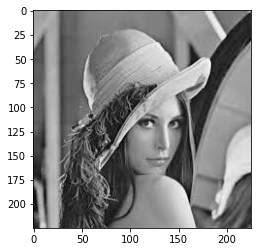

In [286]:
lenna = cv2.imread('lenna.jpg')
bw_lenna = cv2.cvtColor(lenna,cv2.COLOR_BGR2GRAY)
plt.imshow(bw_lenna,cmap='gray')

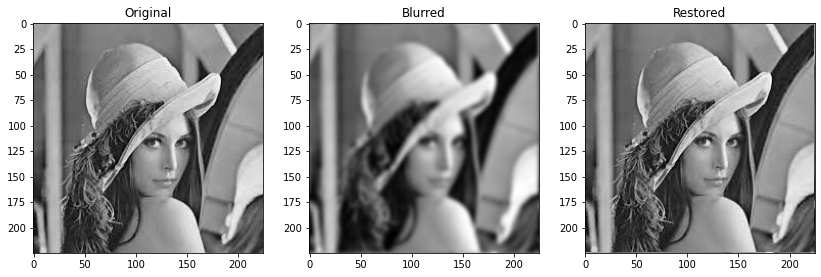

In [332]:
lpass1=(1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]]);
lpass2=(1/16)*np.array([[1,1,1],[1,8,1],[1,1,1]])
kernel = get_gaussian_kernel(size=10,sigma=2)
id_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])

#aca elegimos que kernel probar
kernel2test = kernel

original = bw_lenna.copy()
#blurred = cv2.filter2D(bw_lenna,-1,kernel2test) 
# OJO, NO ES LO MISMO hacer las cosas convolucion que hacer las cosas en F.
# En la teoria anda, en la practica no (filter2D vs ffts).
# A veces tira errores el codigo al restaurar, imagino que es por los 
# 0 de la transferencia que divide en cuyo caso hay que regularizar

blurred = productoftransfersinfreqdom(original,kernel2test)
restored = restoreByInverseFilter(blurred,kernel2test)
fig=plt.figure(figsize=(14, 10))

fig.add_subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original,cmap='gray')
fig.add_subplot(1, 3, 2)
plt.title("Blurred")
plt.imshow(blurred,cmap='gray')
fig.add_subplot(1, 3, 3)
plt.title("Restored")
plt.imshow(restored,cmap='gray')

## Imagen con ruido 

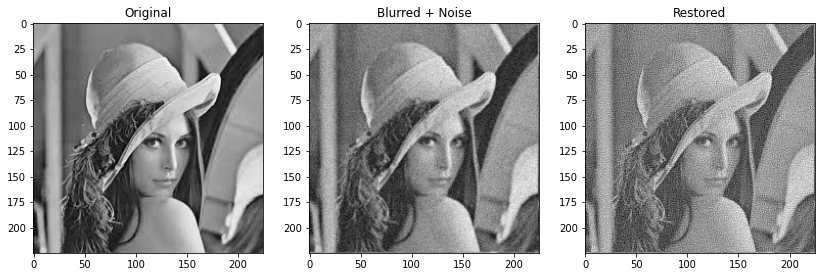

In [343]:
lpass1=(1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]]);
lpass2=(1/16)*np.array([[1,1,1],[1,8,1],[1,1,1]])
kernel = get_gaussian_kernel(size=10,sigma=2)
id_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])

#aca elegimos que kernel probar
kernel2test = lpass2

original = bw_lenna.copy()

blurred = productoftransfersinfreqdom(original,kernel2test)
blurred_plus_noise = add_noise_to_image(blurred,mean=0,std=10)
restored = restoreByInverseFilter(blurred_plus_noise,kernel2test)
fig=plt.figure(figsize=(14, 10))

fig.add_subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original,cmap='gray')
fig.add_subplot(1, 3, 2)
plt.title("Blurred + Noise")
plt.imshow(blurred_plus_noise,cmap='gray')
fig.add_subplot(1, 3, 3)
plt.title("Restored")
plt.imshow(restored,cmap='gray')